In [1]:
# import geomloss

In [1]:
import pandas as pd
from sdv.single_table import TVAESynthesizer

from domias.evaluator import evaluate_performance
from domias.models.generator import GeneratorInterface
from domias.models.ctgan import CTGAN



from scipy import stats
from scipy.stats import multivariate_normal


import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing, fetch_covtype, load_digits

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
df_uci = pd.read_csv(r'C:\Users\jordy\OneDrive\MSc_Python\Individual_Project\Data\UCI_Credit_Card.csv')
df_uci.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
#convert dataframe to array
arr_uci = np.array(df_uci.iloc[:, 1:-1])
arr_uci.shape

(30000, 23)

In [4]:
def get_dataset() -> np.ndarray:
    def data_loader() -> np.ndarray:
        scaler = StandardScaler()
        X =arr_uci
        np.random.shuffle(X)
        return scaler.fit_transform(X)

    return data_loader()

In [5]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 1000 #held out set
training_epochs = [200]
training_sizes = [100]
#synthetic_sizes = [200]
density_estimator = "bnaf"  # prior, kde, bnaf
gen_size = 100 #same as synthetic_sizes

method = "CTGAN"

results={}
    
for training_size in training_sizes:
    # Initialize the result dictionary for the current training size
    size_results = {}

    for training_epoch in training_epochs:
        generator = get_generator(
            gan_method=method,
            epochs=training_epoch,
        )

        perf = evaluate_performance(
            generator,
            dataset,
            training_size,
            reference_set_size,
            training_epochs=training_epoch,
            synthetic_sizes=[gen_size],
            density_estimator=density_estimator,
        )

        # Store the MIA performance for the current training size and epoch
        size_results[training_epoch] = perf[gen_size]["MIA_performance"]

    # Store the results for the current training size
    results[training_size] = size_results


# Print the results
for training_size, size_results in results.items():
    print(f"Training Size {training_size}:")
    for training_epoch, mia_performance in size_results.items():
        print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
    print()


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s, loss=206.13]


Epoch   1/ 50 -- train_loss: 213.314 -- validation_loss: 983.470
Saving model..


100%|████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s, loss=181.32]


Epoch   2/ 50 -- train_loss: 187.286 -- validation_loss: 976.781
Saving model..


100%|████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s, loss=147.79]


Epoch   3/ 50 -- train_loss: 156.080 -- validation_loss: 969.929
Saving model..


100%|████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=127.25]


Epoch   4/ 50 -- train_loss: 131.156 -- validation_loss: 962.927
Saving model..


100%|████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s, loss=106.80]


Epoch   5/ 50 -- train_loss: 111.521 -- validation_loss: 955.890
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=89.50]


Epoch   6/ 50 -- train_loss: 92.980 -- validation_loss: 948.675
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 78.868 -- validation_loss: 941.371
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s, loss=65.26]


Epoch   8/ 50 -- train_loss: 67.689 -- validation_loss: 934.312
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 58.546 -- validation_loss: 927.042
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=50.14]


Epoch  10/ 50 -- train_loss: 52.311 -- validation_loss: 919.820
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 46.018 -- validation_loss: 912.444
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 43.788 -- validation_loss: 905.287
Saving model..


100%|█████████████████████████████████| 2/2 [00:01<00:00,  2.00it/s, loss=39.07]


Epoch  13/ 50 -- train_loss: 40.482 -- validation_loss: 897.989
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s, loss=34.97]


Epoch  14/ 50 -- train_loss: 36.873 -- validation_loss: 890.622
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 34.116 -- validation_loss: 883.323
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s, loss=30.91]


Epoch  16/ 50 -- train_loss: 32.013 -- validation_loss: 876.351
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 30.523 -- validation_loss: 869.157
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 28.989 -- validation_loss: 862.200
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s, loss=27.82]


Epoch  19/ 50 -- train_loss: 27.692 -- validation_loss: 855.433
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=26.32]


Epoch  20/ 50 -- train_loss: 26.510 -- validation_loss: 848.546
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=25.29]


Epoch  21/ 50 -- train_loss: 25.533 -- validation_loss: 841.634
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s, loss=24.12]


Epoch  22/ 50 -- train_loss: 24.182 -- validation_loss: 834.950
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s, loss=22.48]


Epoch  23/ 50 -- train_loss: 23.014 -- validation_loss: 828.302
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s, loss=23.26]


Epoch  24/ 50 -- train_loss: 22.412 -- validation_loss: 821.859
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 21.498 -- validation_loss: 815.424
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s, loss=21.24]


Epoch  26/ 50 -- train_loss: 20.737 -- validation_loss: 809.116
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 19.881 -- validation_loss: 802.746
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=18.36]


Epoch  28/ 50 -- train_loss: 19.491 -- validation_loss: 796.672
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: 19.525 -- validation_loss: 790.687
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.04it/s, loss=19.44]


Epoch  30/ 50 -- train_loss: 18.720 -- validation_loss: 784.635
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s, loss=17.89]


Epoch  31/ 50 -- train_loss: 18.078 -- validation_loss: 778.530
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 17.633 -- validation_loss: 772.633
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: 17.359 -- validation_loss: 767.026
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s, loss=17.05]


Epoch  34/ 50 -- train_loss: 16.876 -- validation_loss: 761.419
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s, loss=16.01]


Epoch  35/ 50 -- train_loss: 16.312 -- validation_loss: 755.818
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: 15.761 -- validation_loss: 750.274
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s, loss=15.11]


Epoch  37/ 50 -- train_loss: 15.758 -- validation_loss: 745.085
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 14.794 -- validation_loss: 739.833
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s, loss=13.48]


Epoch  39/ 50 -- train_loss: 14.104 -- validation_loss: 734.473
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: 15.276 -- validation_loss: 729.389
Saving model..


100%|█████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s, loss=15.13]


Epoch  41/ 50 -- train_loss: 14.831 -- validation_loss: 724.276
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s, loss=14.33]


Epoch  42/ 50 -- train_loss: 13.906 -- validation_loss: 719.253
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s, loss=13.31]


Epoch  43/ 50 -- train_loss: 13.678 -- validation_loss: 714.278
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: 13.745 -- validation_loss: 709.361
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s, loss=13.22]


Epoch  45/ 50 -- train_loss: 13.198 -- validation_loss: 704.396
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: 12.553 -- validation_loss: 699.732
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: 12.704 -- validation_loss: 695.052
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: 12.022 -- validation_loss: 690.417
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: 11.018 -- validation_loss: 685.728
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s, loss=11.42]


Epoch  50/ 50 -- train_loss: 11.435 -- validation_loss: 681.248
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 681.248
Test loss:       679.258
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 88.903 -- validation_loss: 923.029
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.14it/s, loss=18.27]


Epoch   2/ 50 -- train_loss: 25.471 -- validation_loss: 848.268
Saving model..


100%|████████████████████████████████| 20/20 [00:09<00:00,  2.14it/s, loss=8.14]


Epoch   3/ 50 -- train_loss: 13.006 -- validation_loss: 781.416
Saving model..


100%|████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s, loss=6.52]


Epoch   4/ 50 -- train_loss: 6.570 -- validation_loss: 723.616
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 2.657 -- validation_loss: 674.049
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.18it/s, loss=-1.44]


Epoch   6/ 50 -- train_loss: 0.360 -- validation_loss: 631.282
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.21it/s, loss=-0.11]


Epoch   7/ 50 -- train_loss: -1.054 -- validation_loss: 594.143
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.21it/s, loss=-0.79]


Epoch   8/ 50 -- train_loss: -1.787 -- validation_loss: 561.704
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -4.366 -- validation_loss: 533.272
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -4.702 -- validation_loss: 508.305
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.18it/s, loss=-9.70]


Epoch  11/ 50 -- train_loss: -5.435 -- validation_loss: 485.708
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.20it/s, loss=-5.54]


Epoch  12/ 50 -- train_loss: -5.850 -- validation_loss: 465.396
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.21it/s, loss=-11.12]


Epoch  13/ 50 -- train_loss: -6.036 -- validation_loss: 446.542
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.22it/s, loss=-3.68]


Epoch  14/ 50 -- train_loss: -7.383 -- validation_loss: 429.102
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.20it/s, loss=-7.89]


Epoch  15/ 50 -- train_loss: -7.727 -- validation_loss: 412.962
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.18it/s, loss=-9.73]


Epoch  16/ 50 -- train_loss: -8.674 -- validation_loss: 397.711
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.17it/s, loss=-10.91]


Epoch  17/ 50 -- train_loss: -8.861 -- validation_loss: 383.180
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.10it/s, loss=-11.24]


Epoch  18/ 50 -- train_loss: -9.997 -- validation_loss: 369.244
Saving model..


100%|███████████████████████████████| 20/20 [00:10<00:00,  1.96it/s, loss=-5.05]


Epoch  19/ 50 -- train_loss: -9.528 -- validation_loss: 355.913
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -10.380 -- validation_loss: 342.927
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.14it/s, loss=-9.19]


Epoch  21/ 50 -- train_loss: -10.681 -- validation_loss: 330.620
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.13it/s, loss=-12.76]


Epoch  22/ 50 -- train_loss: -11.132 -- validation_loss: 318.967
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.13it/s, loss=-9.73]


Epoch  23/ 50 -- train_loss: -11.639 -- validation_loss: 307.589
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.09it/s, loss=-13.03]


Epoch  24/ 50 -- train_loss: -12.519 -- validation_loss: 296.550
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.21it/s, loss=-13.78]


Epoch  25/ 50 -- train_loss: -13.523 -- validation_loss: 285.730
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-16.34]


Epoch  26/ 50 -- train_loss: -13.133 -- validation_loss: 275.325
Saving model..


100%|███████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-8.45]


Epoch  27/ 50 -- train_loss: -12.481 -- validation_loss: 265.422
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.02it/s, loss=-14.31]


Epoch  28/ 50 -- train_loss: -14.964 -- validation_loss: 255.913
Saving model..


100%|██████████████████████████████| 20/20 [00:10<00:00,  1.98it/s, loss=-15.86]


Epoch  29/ 50 -- train_loss: -15.571 -- validation_loss: 247.147
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.22it/s, loss=-15.29]


Epoch  30/ 50 -- train_loss: -14.985 -- validation_loss: 238.523
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -14.930 -- validation_loss: 230.392
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.20it/s, loss=-15.65]


Epoch  32/ 50 -- train_loss: -14.650 -- validation_loss: 222.569
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.06it/s, loss=-18.05]


Epoch  33/ 50 -- train_loss: -15.227 -- validation_loss: 215.211
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-15.82]


Epoch  34/ 50 -- train_loss: -16.456 -- validation_loss: 208.248
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.17it/s, loss=-19.89]


Epoch  35/ 50 -- train_loss: -16.944 -- validation_loss: 201.605
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-15.18]


Epoch  36/ 50 -- train_loss: -17.617 -- validation_loss: 195.309
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -16.897 -- validation_loss: 189.358
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.12it/s, loss=-14.92]


Epoch  38/ 50 -- train_loss: -17.624 -- validation_loss: 183.745
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.14it/s, loss=-21.10]


Epoch  39/ 50 -- train_loss: -18.599 -- validation_loss: 178.384
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -17.104 -- validation_loss: 173.265
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.12it/s, loss=-20.58]


Epoch  41/ 50 -- train_loss: -19.038 -- validation_loss: 168.368
Saving model..


100%|██████████████████████████████| 20/20 [00:10<00:00,  1.97it/s, loss=-22.06]


Epoch  42/ 50 -- train_loss: -19.407 -- validation_loss: 163.830
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -20.564 -- validation_loss: 159.564
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-19.42]


Epoch  44/ 50 -- train_loss: -20.298 -- validation_loss: 155.545
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -20.239 -- validation_loss: 151.644
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -21.297 -- validation_loss: 147.952
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -21.350 -- validation_loss: 144.532
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -19.601 -- validation_loss: 141.157
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-19.75]


Epoch  49/ 50 -- train_loss: -21.615 -- validation_loss: 137.985
Saving model..


100%|██████████████████████████████| 20/20 [00:09<00:00,  2.16it/s, loss=-22.37]


Epoch  50/ 50 -- train_loss: -21.948 -- validation_loss: 134.978
Saving model..
###### Stop training after 50 epochs!
Validation loss: 134.978
Test loss:       136.031
p_G_evaluated
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
p_R_evaluated
[2.36843474e-28 9.76859324e-27 4.48281412e-09 3.47378947e-39
 8.24606344e-18 7.05681098e-18 9.49234145e-36 1.64910242e-18
 5.31717403e-27 1.40370813e-18 7.28889551e-13 8.74128993e-20
 1.10169828

# Vanilla domias


In [ ]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 1000 #held out set
training_epochs = [200]
training_sizes = [100]
#synthetic_sizes = [200]
density_estimator = "bnaf"  # prior, kde, bnaf
gen_size = 100 #same as synthetic_sizes

method = "CTGAN"

results={}
    
for training_size in training_sizes:
    # Initialize the result dictionary for the current training size
    size_results = {}

    for training_epoch in training_epochs:
        generator = get_generator(
            gan_method=method,
            epochs=training_epoch,
        )

        perf = evaluate_performance(
            generator,
            dataset,
            training_size,
            reference_set_size,
            training_epochs=training_epoch,
            synthetic_sizes=[gen_size],
            density_estimator=density_estimator,
        )

        # Store the MIA performance for the current training size and epoch
        size_results[training_epoch] = perf[gen_size]["MIA_performance"]

    # Store the results for the current training size
    results[training_size] = size_results


# Print the results
for training_size, size_results in results.items():
    print(f"Training Size {training_size}:")
    for training_epoch, mia_performance in size_results.items():
        print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
    print()


In [11]:
output = pd.DataFrame([], columns=["iteration", "epoch", "src", "accuracy"])

for iteration in range(1, num_iterations + 1):
    for training_epoch in training_epochs:
        epoch_res = results[iteration][training_size][training_epoch]
        perf = epoch_res  # Assuming perf is the correct value for accuracy

        for key in perf:
            output = pd.concat(
                [
                    output,
                    pd.DataFrame(
                        [
                            [iteration, training_epoch, key, perf[key]["accuracy"]],
                        ],
                        columns=["iteration", "epoch", "src", "accuracy"],
                    ),
                ]
            )
output

,iteration,epoch,src,accuracy
0,1,100,ablated_eq1,0.5011
0,1,100,ablated_eq2,0.4991
0,1,100,LOGAN_D1,0.5073
0,1,100,MC,0.4994
0,1,100,gan_leaks,0.4994
...,...,...,...,...
0,3,3000,gan_leaks,0.5019
0,3,3000,gan_leaks_cal,0.5040
0,3,3000,LOGAN_0,0.4979
0,3,3000,eq1,0.5000


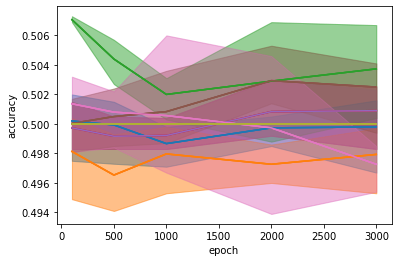

In [14]:
import seaborn as sns
for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output, x="epoch", y="accuracy", hue="src", legend=False)

# Trial BNAF with TVAE

In [13]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
for i, col in enumerate(df_dataset.columns):
    df_dataset.rename(columns={col: f'{i}'}, inplace=True)
df_dataset
    

    
    
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 1000 #held out set
training_epochs = [200]
training_sizes = [100]
#synthetic_sizes = [200]
density_estimator = "bnaf"  # prior, kde, bnaf
gen_size = 100 #same as synthetic_sizes

method = "TVAE"

results={}
    
for training_size in training_sizes:
    # Initialize the result dictionary for the current training size
    size_results = {}

    for training_epoch in training_epochs:
        generator = get_generator(
            gan_method=method,
            epochs=training_epoch,
        )

        perf = evaluate_performance(
            generator,
            dataset,
            training_size,
            reference_set_size,
            training_epochs=training_epoch,
            synthetic_sizes=[gen_size],
            density_estimator=density_estimator,
        )

        # Store the MIA performance for the current training size and epoch
        size_results[training_epoch] = perf[gen_size]["MIA_performance"]

    # Store the results for the current training size
    results[training_size] = size_results


# Print the results
for training_size, size_results in results.items():
    print(f"Training Size {training_size}:")
    for training_epoch, mia_performance in size_results.items():
        print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
    print()


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 141.431 -- validation_loss: 985.645
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 108.477 -- validation_loss: 977.466
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 91.856 -- validation_loss: 969.009
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 77.351 -- validation_loss: 960.346
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 61.961 -- validation_loss: 951.800
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 49.623 -- validation_loss: 943.220
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 38.260 -- validation_loss: 934.483
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 32.451 -- validation_loss: 925.738
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.44it/s, loss=26.03]


Epoch   9/ 50 -- train_loss: 26.598 -- validation_loss: 917.062
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s, loss=22.29]


Epoch  10/ 50 -- train_loss: 22.208 -- validation_loss: 908.475
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 18.305 -- validation_loss: 899.907
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 16.945 -- validation_loss: 891.371
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 14.571 -- validation_loss: 882.854
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 12.787 -- validation_loss: 874.305
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 11.175 -- validation_loss: 866.095
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 9.275 -- validation_loss: 858.009
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 7.720 -- validation_loss: 849.960
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 6.314 -- validation_loss: 841.975
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 4.733 -- validation_loss: 834.018
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 3.818 -- validation_loss: 826.489
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 2.632 -- validation_loss: 819.024
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 1.620 -- validation_loss: 811.655
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 0.832 -- validation_loss: 804.376
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 0.639 -- validation_loss: 797.178
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 0.343 -- validation_loss: 790.049
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s, loss=-0.81]


Epoch  26/ 50 -- train_loss: -0.820 -- validation_loss: 782.974
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: -1.451 -- validation_loss: 776.047
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s, loss=-2.01]


Epoch  28/ 50 -- train_loss: -0.819 -- validation_loss: 769.302
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -1.511 -- validation_loss: 762.631
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s, loss=-3.10]


Epoch  30/ 50 -- train_loss: -2.145 -- validation_loss: 756.179
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -2.641 -- validation_loss: 749.719
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -3.548 -- validation_loss: 743.321
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -3.621 -- validation_loss: 736.998
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -4.032 -- validation_loss: 730.760
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -4.727 -- validation_loss: 724.586
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -4.915 -- validation_loss: 718.635
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: -5.233 -- validation_loss: 712.683
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -5.351 -- validation_loss: 706.812
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -6.114 -- validation_loss: 701.088
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -4.060 -- validation_loss: 695.456
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -5.532 -- validation_loss: 689.891
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -5.515 -- validation_loss: 684.293
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s, loss=-5.56]


Epoch  43/ 50 -- train_loss: -5.347 -- validation_loss: 678.869
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: -4.940 -- validation_loss: 673.513
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -5.787 -- validation_loss: 668.218
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s, loss=-4.79]


Epoch  46/ 50 -- train_loss: -6.235 -- validation_loss: 663.085
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: -6.106 -- validation_loss: 658.015
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s, loss=-6.18]


Epoch  48/ 50 -- train_loss: -7.066 -- validation_loss: 653.045
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -5.564 -- validation_loss: 648.097
Saving model..


100%|█████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s, loss=-5.24]


Epoch  50/ 50 -- train_loss: -6.270 -- validation_loss: 643.284
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

###### Stop training after 50 epochs!
Validation loss: 643.284
Test loss:       641.581
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


100%|███████████████████████████████| 20/20 [00:07<00:00,  2.62it/s, loss=35.74]


Epoch   1/ 50 -- train_loss: 82.150 -- validation_loss: 921.297
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 21.901 -- validation_loss: 845.551
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 9.647 -- validation_loss: 778.745
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 3.395 -- validation_loss: 721.616
Saving model..


100%|███████████████████████████████| 20/20 [00:07<00:00,  2.65it/s, loss=-2.40]


Epoch   5/ 50 -- train_loss: -0.848 -- validation_loss: 672.341
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: -3.687 -- validation_loss: 630.107
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: -5.748 -- validation_loss: 593.438
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: -8.274 -- validation_loss: 561.494
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: -9.103 -- validation_loss: 533.263
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: -10.416 -- validation_loss: 508.193
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: -11.191 -- validation_loss: 485.598
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: -12.904 -- validation_loss: 465.117
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.66it/s, loss=-15.17]


Epoch  13/ 50 -- train_loss: -13.670 -- validation_loss: 446.407
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: -13.616 -- validation_loss: 428.921
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: -14.172 -- validation_loss: 412.556
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: -15.144 -- validation_loss: 397.113
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: -16.037 -- validation_loss: 382.452
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: -15.844 -- validation_loss: 368.436
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: -17.229 -- validation_loss: 354.854
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: -16.465 -- validation_loss: 341.881
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: -17.710 -- validation_loss: 329.380
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: -16.973 -- validation_loss: 317.552
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: -18.082 -- validation_loss: 305.839
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: -18.891 -- validation_loss: 294.882
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.58it/s, loss=-19.03]


Epoch  25/ 50 -- train_loss: -19.266 -- validation_loss: 284.138
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: -19.501 -- validation_loss: 274.007
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.57it/s, loss=-24.36]


Epoch  27/ 50 -- train_loss: -20.480 -- validation_loss: 264.251
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: -18.848 -- validation_loss: 254.954
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: -19.843 -- validation_loss: 246.049
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.62it/s, loss=-17.40]


Epoch  30/ 50 -- train_loss: -21.006 -- validation_loss: 237.583
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: -20.989 -- validation_loss: 229.395
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: -21.347 -- validation_loss: 221.520
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: -20.609 -- validation_loss: 214.074
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: -21.823 -- validation_loss: 207.019
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: -20.684 -- validation_loss: 200.317
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: -21.654 -- validation_loss: 193.956
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.56it/s, loss=-20.45]


Epoch  37/ 50 -- train_loss: -21.740 -- validation_loss: 187.993
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: -22.099 -- validation_loss: 182.230
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: -22.922 -- validation_loss: 176.882
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: -22.796 -- validation_loss: 171.803
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: -23.618 -- validation_loss: 166.992
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: -23.120 -- validation_loss: 162.424
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: -23.787 -- validation_loss: 158.102
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.61it/s, loss=-24.38]


Epoch  44/ 50 -- train_loss: -22.859 -- validation_loss: 154.004
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: -23.690 -- validation_loss: 150.114
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: -24.942 -- validation_loss: 146.475
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.61it/s, loss=-23.96]


Epoch  47/ 50 -- train_loss: -23.836 -- validation_loss: 143.007
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: -24.648 -- validation_loss: 139.768
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: -24.193 -- validation_loss: 136.689
Saving model..


100%|██████████████████████████████| 20/20 [00:07<00:00,  2.61it/s, loss=-25.28]


Epoch  50/ 50 -- train_loss: -25.110 -- validation_loss: 133.824
Saving model..
###### Stop training after 50 epochs!
Validation loss: 133.824
Test loss:       133.144
Training Size 100:
Training Epoch 200: MIA Performance = {'ablated_eq1': {'accuracy': 0.47, 'aucroc': 0.43299999999999994}, 'ablated_eq2': {'accuracy': 0.47, 'aucroc': 0.43199999999999994}, 'LOGAN_D1': {'accuracy': 0.5, 'aucroc': 0.5527}, 'MC': {'accuracy': 0.47, 'aucroc': 0.46625}, 'gan_leaks': {'accuracy': 0.47, 'aucroc': 0.4557}, 'gan_leaks_cal': {'accuracy': 0.49, 'aucroc': 0.4884}, 'LOGAN_0': {'accuracy': 0.51, 'aucroc': 0.4812}, 'eq1': {'accuracy': 0.5, 'aucroc': 0.5}, 'domias': {'accuracy': 0.5, 'aucroc': 0.5}}



# Trial BNAF with california sample dataset

    

    

In [17]:
def get_dataset() -> np.ndarray:
    def data_loader() -> np.ndarray:
        scaler = StandardScaler()
        X = fetch_california_housing().data
        np.random.shuffle(X)
        return scaler.fit_transform(X)

    return data_loader()

In [18]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
for i, col in enumerate(df_dataset.columns):
    df_dataset.rename(columns={col: f'{i}'}, inplace=True)
df_dataset
    

    
    
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 1000 #held out set
training_epochs = [200]
training_sizes = [100]
#synthetic_sizes = [200]
density_estimator = "bnaf"  # prior, kde, bnaf
gen_size = 100 #same as synthetic_sizes

method = "TVAE"

results={}
    
for training_size in training_sizes:
    # Initialize the result dictionary for the current training size
    size_results = {}

    for training_epoch in training_epochs:
        generator = get_generator(
            gan_method=method,
            epochs=training_epoch,
        )

        perf = evaluate_performance(
            generator,
            dataset,
            training_size,
            reference_set_size,
            training_epochs=training_epoch,
            synthetic_sizes=[gen_size],
            density_estimator=density_estimator,
        )

        # Store the MIA performance for the current training size and epoch
        size_results[training_epoch] = perf[gen_size]["MIA_performance"]

    # Store the results for the current training size
    results[training_size] = size_results


# Print the results
for training_size, size_results in results.items():
    print(f"Training Size {training_size}:")
    for training_epoch, mia_performance in size_results.items():
        print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
    print()


 50%|████████████████▌                | 1/2 [00:00<00:00,  8.85it/s, loss=77.95]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.97it/s, loss=70.47]

Epoch   1/ 50 -- train_loss: 76.359 -- validation_loss: 339.022
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.72it/s, loss=59.68]

Epoch   2/ 50 -- train_loss: 67.767 -- validation_loss: 336.699
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.04it/s, loss=51.47]

Epoch   3/ 50 -- train_loss: 58.573 -- validation_loss: 334.729
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  8.55it/s, loss=46.76]

Epoch   4/ 50 -- train_loss: 50.401 -- validation_loss: 332.482
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 43.650 -- validation_loss: 330.166
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.50it/s, loss=30.41]

Epoch   6/ 50 -- train_loss: 36.379 -- validation_loss: 327.782
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.76it/s, loss=28.31]

Epoch   7/ 50 -- train_loss: 29.638 -- validation_loss: 325.269
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  8.91it/s, loss=23.18]

Epoch   8/ 50 -- train_loss: 27.056 -- validation_loss: 322.671
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.82it/s, loss=20.27]

Epoch   9/ 50 -- train_loss: 23.696 -- validation_loss: 320.166
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.93it/s, loss=18.43]

Epoch  10/ 50 -- train_loss: 20.470 -- validation_loss: 317.703
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.50it/s, loss=15.84]

Epoch  11/ 50 -- train_loss: 17.470 -- validation_loss: 315.178
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.50it/s, loss=14.16]

Epoch  12/ 50 -- train_loss: 15.409 -- validation_loss: 312.610
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  8.33it/s, loss=12.21]

Epoch  13/ 50 -- train_loss: 13.601 -- validation_loss: 310.031
Saving model..


 50%|████████████████▌                | 1/2 [00:00<00:00,  9.98it/s, loss=11.21]

Epoch  14/ 50 -- train_loss: 12.018 -- validation_loss: 307.437
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 10.614 -- validation_loss: 304.838
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.50it/s, loss=9.20]

Epoch  16/ 50 -- train_loss: 9.486 -- validation_loss: 302.250
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.78it/s, loss=6.86]

Epoch  17/ 50 -- train_loss: 8.737 -- validation_loss: 299.676
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.50it/s, loss=7.97]

Epoch  18/ 50 -- train_loss: 7.678 -- validation_loss: 297.117
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.41it/s, loss=6.11]

Epoch  19/ 50 -- train_loss: 7.024 -- validation_loss: 294.582
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.11it/s, loss=5.44]

Epoch  20/ 50 -- train_loss: 6.463 -- validation_loss: 292.072
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.54it/s, loss=6.01]

Epoch  21/ 50 -- train_loss: 6.195 -- validation_loss: 289.660
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.35it/s, loss=5.70]

Epoch  22/ 50 -- train_loss: 5.854 -- validation_loss: 287.260
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.61it/s, loss=5.02]

Epoch  23/ 50 -- train_loss: 5.457 -- validation_loss: 284.891
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.55it/s, loss=4.49]

Epoch  24/ 50 -- train_loss: 5.059 -- validation_loss: 282.546
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.28it/s, loss=3.59]

Epoch  25/ 50 -- train_loss: 4.847 -- validation_loss: 280.218
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.06it/s, loss=4.04]

Epoch  26/ 50 -- train_loss: 4.443 -- validation_loss: 277.911
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.85it/s, loss=3.98]

Epoch  27/ 50 -- train_loss: 4.095 -- validation_loss: 275.680
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.67it/s, loss=4.10]

Epoch  28/ 50 -- train_loss: 3.878 -- validation_loss: 273.492
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.99it/s, loss=3.13]

Epoch  29/ 50 -- train_loss: 3.655 -- validation_loss: 271.336
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.20it/s, loss=3.45]

Epoch  30/ 50 -- train_loss: 3.535 -- validation_loss: 269.212
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.63it/s, loss=3.51]

Epoch  31/ 50 -- train_loss: 3.523 -- validation_loss: 267.117
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.64it/s, loss=2.95]

Epoch  32/ 50 -- train_loss: 3.193 -- validation_loss: 265.137
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  8.98it/s, loss=2.48]

Epoch  33/ 50 -- train_loss: 3.084 -- validation_loss: 263.129
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.95it/s, loss=3.44]

Epoch  34/ 50 -- train_loss: 2.918 -- validation_loss: 261.155
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 2.783 -- validation_loss: 259.286
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  8.95it/s, loss=2.60]

Epoch  36/ 50 -- train_loss: 2.681 -- validation_loss: 257.390
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.27it/s, loss=2.35]

Epoch  37/ 50 -- train_loss: 2.566 -- validation_loss: 255.516
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 2.500 -- validation_loss: 253.669
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.82it/s, loss=2.33]

Epoch  39/ 50 -- train_loss: 2.377 -- validation_loss: 251.848
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  7.26it/s, loss=2.46]

Epoch  40/ 50 -- train_loss: 2.291 -- validation_loss: 250.047
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.38it/s, loss=2.12]

Epoch  41/ 50 -- train_loss: 2.229 -- validation_loss: 248.269
Saving model..


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: 2.354 -- validation_loss: 246.512
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.36it/s, loss=1.64]

Epoch  43/ 50 -- train_loss: 2.194 -- validation_loss: 244.778
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.26it/s, loss=2.83]

Epoch  44/ 50 -- train_loss: 2.142 -- validation_loss: 243.049
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  8.51it/s, loss=2.24]

Epoch  45/ 50 -- train_loss: 2.331 -- validation_loss: 241.445
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  8.87it/s, loss=1.69]

Epoch  46/ 50 -- train_loss: 2.001 -- validation_loss: 239.860
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  9.43it/s, loss=2.11]

Epoch  47/ 50 -- train_loss: 2.035 -- validation_loss: 238.298
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  8.80it/s, loss=1.66]

Epoch  48/ 50 -- train_loss: 1.972 -- validation_loss: 236.755
Saving model..


 50%|█████████████████                 | 1/2 [00:00<00:00,  8.82it/s, loss=2.00]

Epoch  49/ 50 -- train_loss: 1.892 -- validation_loss: 235.230
Saving model..


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch  50/ 50 -- train_loss: 2.050 -- validation_loss: 233.803
Saving model..
###### Stop training after 50 epochs!
Validation loss: 233.803
Test loss:       235.100
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  5%|█▌                              | 1/20 [00:00<00:02,  8.70it/s, loss=17.61]

Epoch   1/ 50 -- train_loss: 38.950 -- validation_loss: 324.742
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.62it/s, loss=7.44]

Epoch   2/ 50 -- train_loss: 10.639 -- validation_loss: 299.995
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.43it/s, loss=5.25]

Epoch   3/ 50 -- train_loss: 5.569 -- validation_loss: 277.849
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.11it/s, loss=4.46]

Epoch   4/ 50 -- train_loss: 4.522 -- validation_loss: 258.925
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.41it/s, loss=4.41]

Epoch   5/ 50 -- train_loss: 4.214 -- validation_loss: 242.634
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.95it/s, loss=3.47]

Epoch   6/ 50 -- train_loss: 3.927 -- validation_loss: 228.682
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.27it/s, loss=4.03]

Epoch   7/ 50 -- train_loss: 3.994 -- validation_loss: 216.819
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.56it/s, loss=3.67]

Epoch   8/ 50 -- train_loss: 3.760 -- validation_loss: 206.468
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.74it/s, loss=3.11]

Epoch   9/ 50 -- train_loss: 3.649 -- validation_loss: 197.387
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.24it/s, loss=3.27]

Epoch  10/ 50 -- train_loss: 3.609 -- validation_loss: 189.476
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.15it/s, loss=2.96]

Epoch  11/ 50 -- train_loss: 3.509 -- validation_loss: 182.427
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.60it/s, loss=3.80]

Epoch  12/ 50 -- train_loss: 3.420 -- validation_loss: 176.048
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.05it/s, loss=3.63]

Epoch  13/ 50 -- train_loss: 3.356 -- validation_loss: 170.274
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.28it/s, loss=3.30]

Epoch  14/ 50 -- train_loss: 3.232 -- validation_loss: 164.798
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.34it/s, loss=3.28]

Epoch  15/ 50 -- train_loss: 3.200 -- validation_loss: 159.813
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.22it/s, loss=3.08]

Epoch  16/ 50 -- train_loss: 3.055 -- validation_loss: 154.989
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.85it/s, loss=2.79]

Epoch  17/ 50 -- train_loss: 2.871 -- validation_loss: 150.416
Saving model..


  5%|█▋                               | 1/20 [00:00<00:01,  9.92it/s, loss=2.90]

Epoch  18/ 50 -- train_loss: 2.863 -- validation_loss: 146.030
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.11it/s, loss=2.41]

Epoch  19/ 50 -- train_loss: 2.656 -- validation_loss: 141.963
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.98it/s, loss=3.66]

Epoch  20/ 50 -- train_loss: 2.599 -- validation_loss: 137.997
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.01it/s, loss=2.30]

Epoch  21/ 50 -- train_loss: 2.756 -- validation_loss: 133.963
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.07it/s, loss=3.09]

Epoch  22/ 50 -- train_loss: 2.526 -- validation_loss: 130.025
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.98it/s, loss=1.69]

Epoch  23/ 50 -- train_loss: 2.490 -- validation_loss: 126.344
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.40it/s, loss=2.39]

Epoch  24/ 50 -- train_loss: 2.428 -- validation_loss: 122.634
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.35it/s, loss=2.55]

Epoch  25/ 50 -- train_loss: 2.394 -- validation_loss: 118.938
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.11it/s, loss=2.17]

Epoch  26/ 50 -- train_loss: 2.350 -- validation_loss: 115.224
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.14it/s, loss=2.83]

Epoch  27/ 50 -- train_loss: 2.317 -- validation_loss: 111.505
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.38it/s, loss=1.75]

Epoch  28/ 50 -- train_loss: 2.297 -- validation_loss: 107.974
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.87it/s, loss=1.89]

Epoch  29/ 50 -- train_loss: 2.241 -- validation_loss: 104.524
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.23it/s, loss=1.63]

Epoch  30/ 50 -- train_loss: 2.268 -- validation_loss: 100.935
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.80it/s, loss=2.28]

Epoch  31/ 50 -- train_loss: 2.337 -- validation_loss: 97.389
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.97it/s, loss=2.66]

Epoch  32/ 50 -- train_loss: 2.138 -- validation_loss: 94.055
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.47it/s, loss=1.87]

Epoch  33/ 50 -- train_loss: 2.191 -- validation_loss: 90.903
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.97it/s, loss=2.81]

Epoch  34/ 50 -- train_loss: 2.136 -- validation_loss: 87.889
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.23it/s, loss=2.17]

Epoch  35/ 50 -- train_loss: 2.129 -- validation_loss: 84.890
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.41it/s, loss=2.12]

Epoch  36/ 50 -- train_loss: 2.029 -- validation_loss: 82.055
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.90it/s, loss=2.91]

Epoch  37/ 50 -- train_loss: 2.049 -- validation_loss: 79.353
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.83it/s, loss=2.08]

Epoch  38/ 50 -- train_loss: 2.169 -- validation_loss: 76.774
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.23it/s, loss=1.60]

Epoch  39/ 50 -- train_loss: 2.132 -- validation_loss: 74.276
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  8.95it/s, loss=1.72]

Epoch  40/ 50 -- train_loss: 1.991 -- validation_loss: 71.822
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.09it/s, loss=2.18]

Epoch  41/ 50 -- train_loss: 1.982 -- validation_loss: 69.515
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.21it/s, loss=1.58]

Epoch  42/ 50 -- train_loss: 2.071 -- validation_loss: 67.304
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.11it/s, loss=1.86]

Epoch  43/ 50 -- train_loss: 1.935 -- validation_loss: 65.159
Saving model..


  5%|█▋                               | 1/20 [00:00<00:01,  9.68it/s, loss=2.24]

Epoch  44/ 50 -- train_loss: 1.863 -- validation_loss: 63.123
Saving model..


  5%|█▋                               | 1/20 [00:00<00:01,  9.72it/s, loss=1.63]

Epoch  45/ 50 -- train_loss: 1.880 -- validation_loss: 61.225
Saving model..


  5%|█▋                               | 1/20 [00:00<00:01,  9.68it/s, loss=1.93]

Epoch  46/ 50 -- train_loss: 1.806 -- validation_loss: 59.397
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.13it/s, loss=1.08]

Epoch  47/ 50 -- train_loss: 2.035 -- validation_loss: 57.697
Saving model..


  5%|█▋                               | 1/20 [00:00<00:02,  9.41it/s, loss=2.38]

Epoch  48/ 50 -- train_loss: 1.842 -- validation_loss: 56.055
Saving model..


  5%|█▋                               | 1/20 [00:00<00:01,  9.59it/s, loss=2.24]

Epoch  49/ 50 -- train_loss: 1.984 -- validation_loss: 54.497
Saving model..


100%|████████████████████████████████| 20/20 [00:02<00:00,  9.68it/s, loss=1.78]


Epoch  50/ 50 -- train_loss: 1.889 -- validation_loss: 53.024
Saving model..
###### Stop training after 50 epochs!
Validation loss: 53.024
Test loss:       53.110
Training Size 100:
Training Epoch 200: MIA Performance = {'ablated_eq1': {'accuracy': 0.48, 'aucroc': 0.4861}, 'ablated_eq2': {'accuracy': 0.46, 'aucroc': 0.487}, 'LOGAN_D1': {'accuracy': 0.54, 'aucroc': 0.556}, 'MC': {'accuracy': 0.51, 'aucroc': 0.50105}, 'gan_leaks': {'accuracy': 0.51, 'aucroc': 0.5291}, 'gan_leaks_cal': {'accuracy': 0.53, 'aucroc': 0.558}, 'LOGAN_0': {'accuracy': 0.45, 'aucroc': 0.45840000000000003}, 'eq1': {'accuracy': 0.5, 'aucroc': 0.5}, 'domias': {'accuracy': 0.5, 'aucroc': 0.5}}



# Trial with KDE to see if just BNAF the issue

In [7]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
for i, col in enumerate(df_dataset.columns):
    df_dataset.rename(columns={col: f'{i}'}, inplace=True)
df_dataset
    

    
    
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 1000 #held out set
training_epochs = [200]
training_sizes = [100]
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_size = 100 #same as synthetic_sizes

method = "CTGAN"

results={}
    
for training_size in training_sizes:
    # Initialize the result dictionary for the current training size
    size_results = {}

    for training_epoch in training_epochs:
        generator = get_generator(
            gan_method=method,
            epochs=training_epoch,
        )

        perf = evaluate_performance(
            generator,
            dataset,
            training_size,
            reference_set_size,
            training_epochs=training_epoch,
            synthetic_sizes=[gen_size],
            density_estimator=density_estimator,
        )

        # Store the MIA performance for the current training size and epoch
        size_results[training_epoch] = perf[gen_size]["MIA_performance"]

    # Store the results for the current training size
    results[training_size] = size_results


# Print the results
for training_size, size_results in results.items():
    print(f"Training Size {training_size}:")
    for training_epoch, mia_performance in size_results.items():
        print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
    print()


Synth set            0         1         2         3         4         5         6  \
0  -1.926744 -0.678904 -0.194111  0.443688 -0.246214  0.483035 -0.206311   
1  -0.595391  0.726930  2.660430  1.333540 -0.146274 -2.706156  0.289791   
2  -0.583932  1.227250 -0.404069  0.719757 -0.448163 -0.117039  0.094845   
3  -1.543721  1.143143 -1.022832  0.478252 -0.871955  0.156683  0.383959   
4  -1.245567  0.790838  0.239294  0.935872 -0.093211 -1.704996  0.403159   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.969554  0.712284  0.301662  0.668275 -0.197071 -2.704115  0.278540   
96 -1.112999  0.978461  0.250521  0.734734  0.849111 -0.540759  0.234578   
97 -0.965917  1.360749  1.042048  0.821849 -0.076748 -0.126520  0.456338   
98 -1.711583  0.352418 -0.911020  0.959313  0.033006 -2.192013  0.290543   
99 -0.842634 -1.234554  0.424709  0.268548  2.026984  0.400069  2.028443   

           7         8         9  ...        13        14        15        16

 - Find out what variables the density estimation feeds into the domias model
- Maybe gen_size being so small impacts on BNAF estimation and results in the same density value?? Something short curcuits 

DOMIAS (BNAF for p_R estimation)

if density_estimator == "bnaf":
    p_R_evaluated = np.exp(
        compute_log_p_x(p_R_model, torch.as_tensor(X_test).float().to(device))
        .cpu()
        .detach()
        .numpy()
    )
    
    
acc, auc = compute_metrics_baseline(p_rel, Y_test)


# Trial with epoch=2000 and training size variation

In [19]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
for i, col in enumerate(df_dataset.columns):
    df_dataset.rename(columns={col: f'{i}'}, inplace=True)
df_dataset
    

    
    
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 10000 #held out set
training_epochs = [2000]
training_sizes = [100, 500, 1000]
#synthetic_sizes = [200]
density_estimator = "bnaf"  # prior, kde, bnaf
gen_size = 200 #same as synthetic_sizes

method = "TVAE"

results={}
    
for training_size in training_sizes:
    # Initialize the result dictionary for the current training size
    size_results = {}

    for training_epoch in training_epochs:
        generator = get_generator(
            gan_method=method,
            epochs=training_epoch,
        )

        perf = evaluate_performance(
            generator,
            dataset,
            training_size,
            reference_set_size,
            training_epochs=training_epoch,
            synthetic_sizes=[gen_size],
            density_estimator=density_estimator,
        )

        # Store the MIA performance for the current training size and epoch
        size_results[training_epoch] = perf[gen_size]["MIA_performance"]

    # Store the results for the current training size
    results[training_size] = size_results


# Print the results
for training_size, size_results in results.items():
    print(f"Training Size {training_size}:")
    for training_epoch, mia_performance in size_results.items():
        print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
    print()


 25%|████████▎                        | 1/4 [00:00<00:00,  8.46it/s, loss=56.31]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.22it/s, loss=45.43]

Epoch   1/ 50 -- train_loss: 52.212 -- validation_loss: 335.358
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 42.505 -- validation_loss: 330.244
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.41it/s, loss=27.60]

Epoch   3/ 50 -- train_loss: 33.186 -- validation_loss: 324.963
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 24.299 -- validation_loss: 319.537
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.21it/s, loss=14.30]

Epoch   5/ 50 -- train_loss: 18.111 -- validation_loss: 314.017
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.20it/s, loss=11.87]

Epoch   6/ 50 -- train_loss: 13.393 -- validation_loss: 308.420
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.21it/s, loss=8.54]

Epoch   7/ 50 -- train_loss: 10.495 -- validation_loss: 302.911
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.18it/s, loss=7.49]

Epoch   8/ 50 -- train_loss: 8.126 -- validation_loss: 297.497
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.41it/s, loss=5.84]

Epoch   9/ 50 -- train_loss: 7.303 -- validation_loss: 292.169
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 6.300 -- validation_loss: 286.964
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 5.172 -- validation_loss: 281.923
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.27it/s, loss=4.36]

Epoch  12/ 50 -- train_loss: 4.360 -- validation_loss: 277.087
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.14it/s, loss=3.49]

Epoch  13/ 50 -- train_loss: 3.853 -- validation_loss: 272.413
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.98it/s, loss=3.79]

Epoch  14/ 50 -- train_loss: 3.376 -- validation_loss: 267.885
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.13it/s, loss=2.72]

Epoch  15/ 50 -- train_loss: 3.101 -- validation_loss: 263.462
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.35it/s, loss=2.70]

Epoch  16/ 50 -- train_loss: 2.909 -- validation_loss: 259.245
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.30it/s, loss=2.37]

Epoch  17/ 50 -- train_loss: 2.782 -- validation_loss: 255.244
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.38it/s, loss=2.50]

Epoch  18/ 50 -- train_loss: 2.482 -- validation_loss: 251.315
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.70it/s, loss=1.57]

Epoch  19/ 50 -- train_loss: 2.305 -- validation_loss: 247.542
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.48it/s, loss=1.37]

Epoch  20/ 50 -- train_loss: 2.186 -- validation_loss: 243.883
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.27it/s, loss=1.65]

Epoch  21/ 50 -- train_loss: 1.964 -- validation_loss: 240.288
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.27it/s, loss=1.36]

Epoch  22/ 50 -- train_loss: 1.878 -- validation_loss: 236.894
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.49it/s, loss=1.12]

Epoch  23/ 50 -- train_loss: 1.653 -- validation_loss: 233.530
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.34it/s, loss=1.15]

Epoch  24/ 50 -- train_loss: 1.667 -- validation_loss: 230.354
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.47it/s, loss=1.20]

Epoch  25/ 50 -- train_loss: 1.520 -- validation_loss: 227.346
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 1.454 -- validation_loss: 224.393
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.28it/s, loss=0.88]

Epoch  27/ 50 -- train_loss: 1.360 -- validation_loss: 221.481
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.34it/s, loss=1.34]

Epoch  28/ 50 -- train_loss: 1.186 -- validation_loss: 218.744
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.38it/s, loss=1.62]

Epoch  29/ 50 -- train_loss: 1.184 -- validation_loss: 216.061
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.94it/s, loss=1.56]

Epoch  30/ 50 -- train_loss: 1.194 -- validation_loss: 213.521
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.34it/s, loss=0.73]

Epoch  31/ 50 -- train_loss: 0.883 -- validation_loss: 210.979
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 0.920 -- validation_loss: 208.656
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.34it/s, loss=0.90]

Epoch  33/ 50 -- train_loss: 0.954 -- validation_loss: 206.281
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.14it/s, loss=1.64]

Epoch  34/ 50 -- train_loss: 0.808 -- validation_loss: 204.001
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 0.890 -- validation_loss: 201.833
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.17it/s, loss=0.51]

Epoch  36/ 50 -- train_loss: 0.670 -- validation_loss: 199.677
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.08it/s, loss=1.10]

Epoch  37/ 50 -- train_loss: 0.704 -- validation_loss: 197.596
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.27it/s, loss=0.10]

Epoch  38/ 50 -- train_loss: 0.619 -- validation_loss: 195.514
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.08it/s, loss=0.57]

Epoch  39/ 50 -- train_loss: 0.491 -- validation_loss: 193.605
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.79it/s, loss=0.01]

Epoch  40/ 50 -- train_loss: 0.489 -- validation_loss: 191.679
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.34it/s, loss=0.00]

Epoch  41/ 50 -- train_loss: 0.483 -- validation_loss: 189.807
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.79it/s, loss=0.26]

Epoch  42/ 50 -- train_loss: 0.434 -- validation_loss: 187.996
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.21it/s, loss=-0.05]

Epoch  43/ 50 -- train_loss: 0.392 -- validation_loss: 186.187
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.58it/s, loss=0.63]

Epoch  44/ 50 -- train_loss: 0.490 -- validation_loss: 184.448
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.34it/s, loss=-0.02]

Epoch  45/ 50 -- train_loss: 0.349 -- validation_loss: 182.692
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.07it/s, loss=-0.05]

Epoch  46/ 50 -- train_loss: 0.310 -- validation_loss: 180.995
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.28it/s, loss=0.90]

Epoch  47/ 50 -- train_loss: 0.263 -- validation_loss: 179.267
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.04it/s, loss=0.83]

Epoch  48/ 50 -- train_loss: 0.335 -- validation_loss: 177.646
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  7.55it/s, loss=-0.30]

Epoch  49/ 50 -- train_loss: 0.319 -- validation_loss: 176.069
Saving model..


100%|██████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s, loss=0.38]


Epoch  50/ 50 -- train_loss: 0.151 -- validation_loss: 174.504
Saving model..


  0%|▏                              | 1/200 [00:00<00:26,  7.61it/s, loss=86.53]

###### Stop training after 50 epochs!
Validation loss: 174.504
Test loss:       174.612
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 11.975 -- validation_loss: 187.273
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 3.694 -- validation_loss: 138.176
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 3.157 -- validation_loss: 103.814
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 2.837 -- validation_loss: 75.669
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 2.617 -- validation_loss: 55.051
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 2.551 -- validation_loss: 42.012
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 2.430 -- validation_loss: 34.293
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 2.324 -- validation_loss: 29.920
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 2.201 -- validation_loss: 27.724
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 2.130 -- validation_loss: 26.445
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 2.103 -- validation_loss: 25.689
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 2.061 -- validation_loss: 25.242
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 2.009 -- validation_loss: 25.042
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 1.981 -- validation_loss: 24.895
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 1.927 -- validation_loss: 24.838
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 1.888 -- validation_loss: 24.850


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 1.784 -- validation_loss: 24.920


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 1.777 -- validation_loss: 25.019


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 1.770 -- validation_loss: 25.075


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 1.751 -- validation_loss: 25.109


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 1.651 -- validation_loss: 25.199


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 1.647 -- validation_loss: 25.218


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 1.591 -- validation_loss: 25.308


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 1.584 -- validation_loss: 25.400


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 1.570 -- validation_loss: 25.478


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 1.545 -- validation_loss: 25.470


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 1.469 -- validation_loss: 25.553


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 1.502 -- validation_loss: 25.664


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: 1.427 -- validation_loss: 25.761


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: 1.423 -- validation_loss: 25.909


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: 1.435 -- validation_loss: 25.976


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 1.394 -- validation_loss: 26.052


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: 1.364 -- validation_loss: 26.238


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: 1.326 -- validation_loss: 26.386


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 1.373 -- validation_loss: 26.381


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: 1.329 -- validation_loss: 26.318
Epoch 00036: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: 1.093 -- validation_loss: 26.472


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 1.064 -- validation_loss: 26.671


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: 1.041 -- validation_loss: 26.850


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: 1.016 -- validation_loss: 27.019


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: 1.008 -- validation_loss: 27.133


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: 0.998 -- validation_loss: 27.193


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: 0.985 -- validation_loss: 27.242


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: 0.950 -- validation_loss: 27.329


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: 0.964 -- validation_loss: 27.335


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: 0.937 -- validation_loss: 27.311


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: 0.915 -- validation_loss: 27.415


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: 0.918 -- validation_loss: 27.464


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: 0.932 -- validation_loss: 27.408


100%|██████████████████████████████| 200/200 [00:25<00:00,  7.83it/s, loss=0.14]


Epoch  50/ 50 -- train_loss: 0.870 -- validation_loss: 27.455
###### Stop training after 50 epochs!
Validation loss: 27.455
Test loss:       27.583


 25%|████████▎                        | 1/4 [00:00<00:00,  7.68it/s, loss=62.49]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.22it/s, loss=50.00]

Epoch   1/ 50 -- train_loss: 57.291 -- validation_loss: 337.356
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 43.378 -- validation_loss: 332.209
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.43it/s, loss=26.92]

Epoch   3/ 50 -- train_loss: 32.810 -- validation_loss: 326.910
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.58it/s, loss=17.23]

Epoch   4/ 50 -- train_loss: 23.383 -- validation_loss: 321.537
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  7.96it/s, loss=11.38]

Epoch   5/ 50 -- train_loss: 15.444 -- validation_loss: 316.074
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.90it/s, loss=9.91]

Epoch   6/ 50 -- train_loss: 11.631 -- validation_loss: 310.633
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.58it/s, loss=8.42]

Epoch   7/ 50 -- train_loss: 9.495 -- validation_loss: 305.273
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=6.72]

Epoch   8/ 50 -- train_loss: 7.486 -- validation_loss: 299.989
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.06it/s, loss=6.46]

Epoch   9/ 50 -- train_loss: 6.627 -- validation_loss: 294.785
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.50it/s, loss=5.55]

Epoch  10/ 50 -- train_loss: 5.895 -- validation_loss: 289.642
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.08it/s, loss=5.55]

Epoch  11/ 50 -- train_loss: 5.127 -- validation_loss: 284.700
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.65it/s, loss=4.50]

Epoch  12/ 50 -- train_loss: 4.736 -- validation_loss: 279.918
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 4.394 -- validation_loss: 275.196
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.63it/s, loss=3.99]

Epoch  14/ 50 -- train_loss: 4.159 -- validation_loss: 270.661
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=3.75]

Epoch  15/ 50 -- train_loss: 3.791 -- validation_loss: 266.256
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 3.552 -- validation_loss: 261.915
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.42it/s, loss=2.59]

Epoch  17/ 50 -- train_loss: 3.411 -- validation_loss: 257.744
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.73it/s, loss=3.95]

Epoch  18/ 50 -- train_loss: 3.330 -- validation_loss: 253.782
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.32it/s, loss=2.95]

Epoch  19/ 50 -- train_loss: 3.338 -- validation_loss: 249.843
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=3.24]

Epoch  20/ 50 -- train_loss: 3.090 -- validation_loss: 246.151
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.70]

Epoch  21/ 50 -- train_loss: 3.270 -- validation_loss: 242.469
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.73]

Epoch  22/ 50 -- train_loss: 2.863 -- validation_loss: 238.812
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.51it/s, loss=3.11]

Epoch  23/ 50 -- train_loss: 2.826 -- validation_loss: 235.399
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=3.25]

Epoch  24/ 50 -- train_loss: 2.758 -- validation_loss: 232.091
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.32it/s, loss=2.81]

Epoch  25/ 50 -- train_loss: 2.782 -- validation_loss: 228.909
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.48]

Epoch  26/ 50 -- train_loss: 2.722 -- validation_loss: 225.756
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.18it/s, loss=2.50]

Epoch  27/ 50 -- train_loss: 2.731 -- validation_loss: 222.649
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.90it/s, loss=2.91]

Epoch  28/ 50 -- train_loss: 2.756 -- validation_loss: 219.782
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=1.90]

Epoch  29/ 50 -- train_loss: 2.532 -- validation_loss: 216.926
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: 2.386 -- validation_loss: 214.111
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.73it/s, loss=2.20]

Epoch  31/ 50 -- train_loss: 2.365 -- validation_loss: 211.357
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=2.58]

Epoch  32/ 50 -- train_loss: 2.482 -- validation_loss: 208.772
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: 2.376 -- validation_loss: 206.225
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.10it/s, loss=1.62]

Epoch  34/ 50 -- train_loss: 2.159 -- validation_loss: 203.712
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.26it/s, loss=2.00]

Epoch  35/ 50 -- train_loss: 2.262 -- validation_loss: 201.327
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.16it/s, loss=1.86]

Epoch  36/ 50 -- train_loss: 2.179 -- validation_loss: 199.009
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: 2.170 -- validation_loss: 196.743
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.55]

Epoch  38/ 50 -- train_loss: 2.097 -- validation_loss: 194.582
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.09it/s, loss=1.51]

Epoch  39/ 50 -- train_loss: 2.026 -- validation_loss: 192.440
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.16it/s, loss=1.68]

Epoch  40/ 50 -- train_loss: 2.019 -- validation_loss: 190.411
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=1.46]

Epoch  41/ 50 -- train_loss: 1.947 -- validation_loss: 188.370
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.16it/s, loss=2.46]

Epoch  42/ 50 -- train_loss: 2.000 -- validation_loss: 186.433
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=1.77]

Epoch  43/ 50 -- train_loss: 1.973 -- validation_loss: 184.501
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.46it/s, loss=1.80]

Epoch  44/ 50 -- train_loss: 1.893 -- validation_loss: 182.685
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.59]

Epoch  45/ 50 -- train_loss: 1.859 -- validation_loss: 180.822
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.16it/s, loss=1.52]

Epoch  46/ 50 -- train_loss: 2.105 -- validation_loss: 179.041
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.19it/s, loss=1.36]

Epoch  47/ 50 -- train_loss: 1.871 -- validation_loss: 177.160
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.18]

Epoch  48/ 50 -- train_loss: 1.651 -- validation_loss: 175.553
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.33it/s, loss=1.83]

Epoch  49/ 50 -- train_loss: 1.853 -- validation_loss: 173.823
Saving model..


100%|██████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s, loss=2.66]


Epoch  50/ 50 -- train_loss: 1.937 -- validation_loss: 172.125
Saving model..


  0%|▏                              | 1/200 [00:00<00:25,  7.80it/s, loss=72.04]

###### Stop training after 50 epochs!
Validation loss: 172.125
Test loss:       172.253
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 8.611 -- validation_loss: 187.600
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 3.187 -- validation_loss: 133.085
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 2.762 -- validation_loss: 94.851
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 2.568 -- validation_loss: 66.584
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 2.430 -- validation_loss: 49.021
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 2.277 -- validation_loss: 38.852
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 2.212 -- validation_loss: 32.860
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 2.144 -- validation_loss: 29.554
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 2.067 -- validation_loss: 27.679
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 2.009 -- validation_loss: 26.654
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 1.973 -- validation_loss: 26.001
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 1.908 -- validation_loss: 25.652
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 1.850 -- validation_loss: 25.508
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 1.840 -- validation_loss: 25.377
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 1.750 -- validation_loss: 25.397


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 1.727 -- validation_loss: 25.427


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 1.715 -- validation_loss: 25.426


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 1.701 -- validation_loss: 25.401


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 1.635 -- validation_loss: 25.468


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 1.603 -- validation_loss: 25.515


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 1.576 -- validation_loss: 25.681


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 1.527 -- validation_loss: 25.722


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 1.580 -- validation_loss: 25.820


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 1.508 -- validation_loss: 25.902


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 1.482 -- validation_loss: 25.928


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 1.435 -- validation_loss: 25.979


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 1.412 -- validation_loss: 26.041


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 1.387 -- validation_loss: 26.160


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: 1.443 -- validation_loss: 26.203


  0%|▏                               | 1/200 [00:00<00:39,  5.05it/s, loss=0.10]

Epoch  30/ 50 -- train_loss: 1.411 -- validation_loss: 26.265


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: 1.357 -- validation_loss: 26.372


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 1.356 -- validation_loss: 26.447


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: 1.285 -- validation_loss: 26.572


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: 1.275 -- validation_loss: 26.638


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 1.238 -- validation_loss: 26.717
Epoch 00035: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: 1.048 -- validation_loss: 26.938


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: 1.129 -- validation_loss: 27.109


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 1.124 -- validation_loss: 27.200


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: 1.104 -- validation_loss: 27.367


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: 1.096 -- validation_loss: 27.459


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: 1.084 -- validation_loss: 27.532


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: 1.038 -- validation_loss: 27.628


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: 1.050 -- validation_loss: 27.714


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: 1.025 -- validation_loss: 27.781


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: 1.014 -- validation_loss: 27.826


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: 0.992 -- validation_loss: 27.872


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: 1.006 -- validation_loss: 27.923


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: 0.998 -- validation_loss: 27.984


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: 0.958 -- validation_loss: 28.010


100%|██████████████████████████████| 200/200 [00:25<00:00,  7.80it/s, loss=0.01]


Epoch  50/ 50 -- train_loss: 0.960 -- validation_loss: 28.046
###### Stop training after 50 epochs!
Validation loss: 28.046
Test loss:       28.068


 25%|████████▎                        | 1/4 [00:00<00:00,  7.26it/s, loss=55.56]

Loading dataset..
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 50.101 -- validation_loss: 337.403
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.50it/s, loss=30.88]

Epoch   2/ 50 -- train_loss: 38.397 -- validation_loss: 332.643
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.12it/s, loss=20.70]

Epoch   3/ 50 -- train_loss: 27.481 -- validation_loss: 327.695
Saving model..


 25%|████████▎                        | 1/4 [00:00<00:00,  8.22it/s, loss=12.52]

Epoch   4/ 50 -- train_loss: 17.423 -- validation_loss: 322.542
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.32it/s, loss=7.01]

Epoch   5/ 50 -- train_loss: 10.281 -- validation_loss: 317.227
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.58it/s, loss=6.49]

Epoch   6/ 50 -- train_loss: 6.669 -- validation_loss: 311.891
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.66it/s, loss=5.74]

Epoch   7/ 50 -- train_loss: 5.903 -- validation_loss: 306.500
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.50it/s, loss=5.27]

Epoch   8/ 50 -- train_loss: 5.678 -- validation_loss: 301.117
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.50it/s, loss=4.75]

Epoch   9/ 50 -- train_loss: 5.277 -- validation_loss: 295.783
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=3.97]

Epoch  10/ 50 -- train_loss: 4.671 -- validation_loss: 290.683
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.62it/s, loss=3.69]

Epoch  11/ 50 -- train_loss: 4.141 -- validation_loss: 285.725
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.29it/s, loss=3.76]

Epoch  12/ 50 -- train_loss: 4.038 -- validation_loss: 280.882
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.50it/s, loss=3.75]

Epoch  13/ 50 -- train_loss: 3.797 -- validation_loss: 276.163
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.66it/s, loss=3.83]

Epoch  14/ 50 -- train_loss: 3.719 -- validation_loss: 271.556
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.69it/s, loss=3.85]

Epoch  15/ 50 -- train_loss: 3.632 -- validation_loss: 267.074
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=3.00]

Epoch  16/ 50 -- train_loss: 3.423 -- validation_loss: 262.763
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.42it/s, loss=2.49]

Epoch  17/ 50 -- train_loss: 3.264 -- validation_loss: 258.659
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.09it/s, loss=3.19]

Epoch  18/ 50 -- train_loss: 3.120 -- validation_loss: 254.641
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.54]

Epoch  19/ 50 -- train_loss: 3.041 -- validation_loss: 250.771
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.73it/s, loss=3.14]

Epoch  20/ 50 -- train_loss: 3.006 -- validation_loss: 247.019
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.56it/s, loss=3.22]

Epoch  21/ 50 -- train_loss: 2.970 -- validation_loss: 243.372
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.45]

Epoch  22/ 50 -- train_loss: 3.047 -- validation_loss: 239.818
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.22]

Epoch  23/ 50 -- train_loss: 2.914 -- validation_loss: 236.357
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.73]

Epoch  24/ 50 -- train_loss: 2.899 -- validation_loss: 233.038
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=3.43]

Epoch  25/ 50 -- train_loss: 2.720 -- validation_loss: 229.890
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.58it/s, loss=2.83]

Epoch  26/ 50 -- train_loss: 2.656 -- validation_loss: 226.801
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=2.48]

Epoch  27/ 50 -- train_loss: 2.634 -- validation_loss: 223.842
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 2.548 -- validation_loss: 220.950
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.06it/s, loss=2.80]

Epoch  29/ 50 -- train_loss: 2.601 -- validation_loss: 218.135
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.04]

Epoch  30/ 50 -- train_loss: 2.530 -- validation_loss: 215.474
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=1.87]

Epoch  31/ 50 -- train_loss: 2.519 -- validation_loss: 212.923
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=2.61]

Epoch  32/ 50 -- train_loss: 2.508 -- validation_loss: 210.433
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.02]

Epoch  33/ 50 -- train_loss: 2.492 -- validation_loss: 208.012
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.47it/s, loss=2.67]

Epoch  34/ 50 -- train_loss: 2.375 -- validation_loss: 205.639
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 2.339 -- validation_loss: 203.307
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.38it/s, loss=2.45]

Epoch  36/ 50 -- train_loss: 2.344 -- validation_loss: 201.108
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=2.02]

Epoch  37/ 50 -- train_loss: 2.336 -- validation_loss: 198.969
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.32it/s, loss=2.72]

Epoch  38/ 50 -- train_loss: 2.283 -- validation_loss: 196.864
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.16it/s, loss=2.05]

Epoch  39/ 50 -- train_loss: 2.391 -- validation_loss: 194.791
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.19it/s, loss=1.95]

Epoch  40/ 50 -- train_loss: 2.334 -- validation_loss: 192.750
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.29it/s, loss=2.35]

Epoch  41/ 50 -- train_loss: 2.315 -- validation_loss: 190.743
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.29it/s, loss=1.82]

Epoch  42/ 50 -- train_loss: 2.338 -- validation_loss: 188.780
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.22it/s, loss=2.19]

Epoch  43/ 50 -- train_loss: 2.370 -- validation_loss: 186.907
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.99it/s, loss=2.06]

Epoch  44/ 50 -- train_loss: 2.236 -- validation_loss: 185.027
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.36it/s, loss=2.03]

Epoch  45/ 50 -- train_loss: 2.223 -- validation_loss: 183.159
Saving model..


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: 2.155 -- validation_loss: 181.456
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.09it/s, loss=1.69]

Epoch  47/ 50 -- train_loss: 2.110 -- validation_loss: 179.868
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  8.43it/s, loss=2.16]

Epoch  48/ 50 -- train_loss: 2.079 -- validation_loss: 178.166
Saving model..


 25%|████████▌                         | 1/4 [00:00<00:00,  7.45it/s, loss=1.96]

Epoch  49/ 50 -- train_loss: 2.027 -- validation_loss: 176.607
Saving model..


100%|██████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s, loss=2.18]


Epoch  50/ 50 -- train_loss: 2.147 -- validation_loss: 175.114
Saving model..


  0%|▏                              | 1/200 [00:00<00:26,  7.63it/s, loss=63.30]

###### Stop training after 50 epochs!
Validation loss: 175.114
Test loss:       173.659
Loading dataset..
No validation set passed
No test set passed
Creating directory experiment..
Creating BNAF model..
Creating optimizer..
Creating scheduler..
Training..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   1/ 50 -- train_loss: 8.946 -- validation_loss: 178.964
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   2/ 50 -- train_loss: 3.300 -- validation_loss: 126.231
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   3/ 50 -- train_loss: 2.815 -- validation_loss: 90.973
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   4/ 50 -- train_loss: 2.528 -- validation_loss: 65.889
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   5/ 50 -- train_loss: 2.359 -- validation_loss: 49.296
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   6/ 50 -- train_loss: 2.262 -- validation_loss: 39.989
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   7/ 50 -- train_loss: 2.184 -- validation_loss: 34.475
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   8/ 50 -- train_loss: 2.044 -- validation_loss: 31.463
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch   9/ 50 -- train_loss: 2.021 -- validation_loss: 29.607
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  10/ 50 -- train_loss: 1.948 -- validation_loss: 28.617
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  11/ 50 -- train_loss: 1.889 -- validation_loss: 27.916
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  12/ 50 -- train_loss: 1.853 -- validation_loss: 27.516
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  13/ 50 -- train_loss: 1.771 -- validation_loss: 27.345
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  14/ 50 -- train_loss: 1.769 -- validation_loss: 27.298
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  15/ 50 -- train_loss: 1.730 -- validation_loss: 27.303


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  16/ 50 -- train_loss: 1.696 -- validation_loss: 27.291
Saving model..


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  17/ 50 -- train_loss: 1.670 -- validation_loss: 27.367


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  18/ 50 -- train_loss: 1.623 -- validation_loss: 27.452


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  19/ 50 -- train_loss: 1.576 -- validation_loss: 27.641


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  20/ 50 -- train_loss: 1.597 -- validation_loss: 27.863


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  21/ 50 -- train_loss: 1.547 -- validation_loss: 27.929


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  22/ 50 -- train_loss: 1.582 -- validation_loss: 28.067


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  23/ 50 -- train_loss: 1.621 -- validation_loss: 28.075


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  24/ 50 -- train_loss: 1.445 -- validation_loss: 28.180


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  25/ 50 -- train_loss: 1.470 -- validation_loss: 28.350


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  26/ 50 -- train_loss: 1.427 -- validation_loss: 28.479


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  27/ 50 -- train_loss: 1.359 -- validation_loss: 28.622


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  28/ 50 -- train_loss: 1.361 -- validation_loss: 28.742


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  29/ 50 -- train_loss: 1.464 -- validation_loss: 28.745


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  30/ 50 -- train_loss: 1.308 -- validation_loss: 28.865


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  31/ 50 -- train_loss: 1.289 -- validation_loss: 29.157


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  32/ 50 -- train_loss: 1.390 -- validation_loss: 29.207


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  33/ 50 -- train_loss: 1.359 -- validation_loss: 29.316


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  34/ 50 -- train_loss: 1.224 -- validation_loss: 29.469


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  35/ 50 -- train_loss: 1.345 -- validation_loss: 29.477


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  36/ 50 -- train_loss: 1.179 -- validation_loss: 29.596


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  37/ 50 -- train_loss: 1.190 -- validation_loss: 29.810
Epoch 00037: reducing learning rate of group 0 to 5.0000e-03.


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  38/ 50 -- train_loss: 0.968 -- validation_loss: 30.121


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  39/ 50 -- train_loss: 0.893 -- validation_loss: 30.445


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  40/ 50 -- train_loss: 0.883 -- validation_loss: 30.776


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  41/ 50 -- train_loss: 0.879 -- validation_loss: 30.981


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  42/ 50 -- train_loss: 0.825 -- validation_loss: 31.212


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  43/ 50 -- train_loss: 0.845 -- validation_loss: 31.408


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  44/ 50 -- train_loss: 0.812 -- validation_loss: 31.501


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  45/ 50 -- train_loss: 0.884 -- validation_loss: 31.643


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  46/ 50 -- train_loss: 0.796 -- validation_loss: 31.738


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  47/ 50 -- train_loss: 0.827 -- validation_loss: 31.877


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  48/ 50 -- train_loss: 0.807 -- validation_loss: 31.886


  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch  49/ 50 -- train_loss: 0.791 -- validation_loss: 31.936


100%|██████████████████████████████| 200/200 [00:25<00:00,  7.91it/s, loss=1.57]


Epoch  50/ 50 -- train_loss: 0.791 -- validation_loss: 32.006
###### Stop training after 50 epochs!
Validation loss: 32.006
Test loss:       32.104
Training Size 100:
Training Epoch 2000: MIA Performance = {'ablated_eq1': {'accuracy': 0.6, 'aucroc': 0.6441000000000001}, 'ablated_eq2': {'accuracy': 0.6, 'aucroc': 0.6553000000000001}, 'LOGAN_D1': {'accuracy': 0.44, 'aucroc': 0.43200000000000005}, 'MC': {'accuracy': 0.57, 'aucroc': 0.5658}, 'gan_leaks': {'accuracy': 0.57, 'aucroc': 0.5791000000000001}, 'gan_leaks_cal': {'accuracy': 0.56, 'aucroc': 0.5911}, 'LOGAN_0': {'accuracy': 0.49, 'aucroc': 0.5009}, 'eq1': {'accuracy': 0.5, 'aucroc': 0.5}, 'domias': {'accuracy': 0.5, 'aucroc': 0.5}}

Training Size 500:
Training Epoch 2000: MIA Performance = {'ablated_eq1': {'accuracy': 0.522, 'aucroc': 0.529604}, 'ablated_eq2': {'accuracy': 0.528, 'aucroc': 0.5511999999999999}, 'LOGAN_D1': {'accuracy': 0.482, 'aucroc': 0.4833}, 'MC': {'accuracy': 0.536, 'aucroc': 0.5419560000000001}, 'gan_leaks': {'a